# Introduction to Data Science
## Homework 4 

Student Name: Joyce Wu

Student Netid: jmw784
***

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection as well as bootstrapping for error estimation. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation (5 Points)
Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the data so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

<b>Grading guideline: if this function is done in more than 20 lines (not including empty lines), we will deduct 2 points.</b>

In [1]:
#Don't forget to import the packages you'll need here.
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale

def cleanBosonData(infile_name):
    
    data_clean = pd.read_csv(infile_name,index_col='EventId', na_values=[-999])
    numFeatures = data_clean.shape[1]
    
    #Create a dictionary with the classes, and map the minority class to 1
    #Note: Should probably not check for minority class within this function because it may end up being different
    #between train and test, but in this case, it turns out to be the same.
    labels = data_clean['Label'].value_counts().index
    mapLabels = {labels.values[-1]: 1, labels.values[0]: 0}
    data_clean['Y']=data_clean['Label'].map(mapLabels)
    
    #Drop Label
    data_clean.drop('Label',1,inplace=True)
    
    #Replace NaN with mean
    for i in data_clean.columns:
        if np.sum(data_clean[i].isnull()) > 0:
            data_clean[i+'_mv'] = data_clean[i].isnull().astype(int)
            data_clean[i].fillna(data_clean[i].mean(),inplace=True)
    
    #Normalize remaining data
    for feature in range(numFeatures-1):
        scale(data_clean.iloc[:,feature],axis=0,copy=False)
        
    return data_clean

### Part 2: Basic evaluations (5 Points)
In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1\. Clean the two data files included in this assignment (`data/boson_training_cut_2000.csv` and `data/boson_testing_cut.csv`) by using the function defined above, and use them as training and testing data sets.

In [2]:
#Student put code here

data_train = cleanBosonData('boson_training_cut_2000.csv')
data_test =  cleanBosonData('boson_testing_cut.csv')

data_train.T

EventId,100000,100001,100002,100003,100004,100005,100006,100007,100008,100009,...,101989,101990,101991,101992,101993,101994,101995,101996,101997,101998
DER_mass_MMC,0.398362,8.633960e-01,-3.235580e-15,5.108589e-01,1.172363e+00,-0.610193,0.611226,7.387702e-01,-2.821220e-01,1.827460e-01,...,-3.235580e-15,-1.280453e+00,2.309498,-0.726022,-6.377639e-01,-4.169521e-01,-8.979135e-02,-1.313012e+00,1.843533,0.374808
DER_mass_transverse_met_lep,0.092601,6.081171e-01,3.421843e+00,9.891588e-01,-9.539161e-01,-1.055284,-0.594022,-1.149633e+00,5.958443e-02,1.215814e+00,...,1.011571e+00,-9.989340e-02,2.697686,-0.626767,-1.414034e+00,2.849741e-01,-6.232120e-01,9.124502e-02,0.735452,-1.217865
DER_mass_vis,0.491173,6.393634e-01,1.261884e+00,2.851645e-02,1.504447e+00,-0.568684,0.763961,4.058704e-01,5.778184e-01,-2.912931e-01,...,-5.042891e-02,-1.063155e+00,1.005400,-0.724986,-4.334825e-01,-3.155440e-01,-2.505460e-02,-9.946221e-01,2.252332,-0.084325
DER_pt_h,-0.444021,-1.207443e-01,-3.213056e-01,-8.859261e-01,-6.295777e-01,0.972524,0.808785,-4.249607e-01,-8.238228e-01,2.207664e+00,...,-5.501291e-01,7.949634e-02,-0.758433,0.428920,-5.364869e-01,-7.362146e-01,4.608817e-02,3.187239e-01,0.372539,0.522139
DER_deltaeta_jet_jet,-1.650125,-4.978417e-16,-4.978417e-16,-4.978417e-16,-4.978417e-16,0.284790,-1.848549,-4.978417e-16,-4.978417e-16,-4.978417e-16,...,-4.978417e-16,-4.978417e-16,-1.432643,1.108754,-4.978417e-16,-4.978417e-16,-4.978417e-16,-4.978417e-16,0.116634,-2.460637
DER_mass_jet_jet,-1.135322,2.786711e-16,2.786711e-16,2.786711e-16,2.786711e-16,-0.351555,-0.970365,2.786711e-16,2.786711e-16,2.786711e-16,...,2.786711e-16,2.786711e-16,-1.335822,-0.484019,2.786711e-16,2.786711e-16,2.786711e-16,2.786711e-16,-0.794098,-1.365422
DER_prodeta_jet_jet,1.873193,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.097683,0.459320,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.238904,0.120389,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.303829,3.367369
DER_deltar_tau_lep,0.888048,1.421917e+00,9.976932e-01,1.209152e+00,1.967534e+00,-1.333579,0.727495,6.700620e-01,6.791992e-01,-1.011169e+00,...,3.215460e-01,-1.144310e+00,1.077317,-0.491658,5.525847e-01,5.055938e-01,-1.783283e-02,-1.710811e+00,0.860636,-0.516459
DER_pt_tot,1.120050,-8.063895e-01,-4.555213e-01,-8.868311e-01,-1.137898e-01,2.071958,-0.783814,-8.330744e-01,-6.995531e-01,4.882649e-01,...,1.257945e-01,-8.703947e-01,0.490199,0.228812,1.669338e-01,-4.353626e-01,-8.149461e-01,-8.027155e-01,-0.679394,-0.670403
Y,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,1.000000e+00,0.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000,1.000000


2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference.

In [3]:
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

X_train = data_train.drop('Y', 1)
Y_train = data_train['Y']
X_test = data_test.drop('Y', 1)
Y_test = data_test['Y']

logreg = linear_model.LogisticRegression(C = 1e30)
logreg.fit(X_train, Y_train)
test_predict_LR = logreg.predict(X_test)
posProb_LR = [i[1] for i in logreg.predict_proba(X_test)]

fpr_LR, tpr_LR, thresholds_LR = roc_curve(Y_test, posProb_LR, pos_label=1)
roc_auc_LR = roc_auc_score(Y_test, posProb_LR)

In [4]:
clf = svm.SVC(kernel="linear", probability=True)
clf.fit(X_train, Y_train)
test_predict_SVM = clf.predict(X_test)
posProb_SVM = [i[1] for i in clf.predict_proba(X_test)]

fpr_SVM, tpr_SVM, thresholds_SVM = roc_curve(Y_test, posProb_SVM, pos_label=1)
roc_auc_SVM = roc_auc_score(Y_test, posProb_SVM)

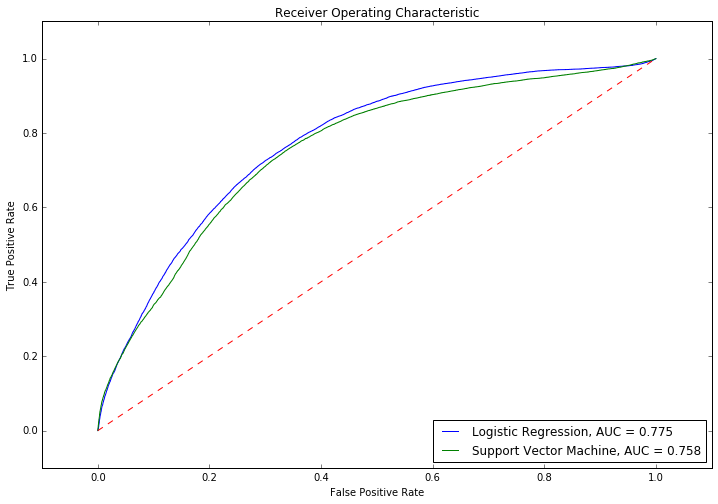

In [5]:
fig = plt.figure(figsize = (12, 8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_LR, tpr_LR, 'b',
label='Logistic Regression, AUC = %0.3f'% roc_auc_LR)
plt.plot(fpr_SVM, tpr_SVM, 'g',
label='Support Vector Machine, AUC = %0.3f'% roc_auc_SVM)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

Logistic regression is generally better at ranking the test set with a higher AUC score of 0.775 compared to 0.758.

Yes, the logistic regression model would underperform the SVM in TPR for thresholds in which the FPR are 0 to 0.5, but the difference looks negligible and within the margin of error.

### Part 3: Model selection with cross-validation (7 Points)
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 2000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Performs two loops
  - Outer Loop: `for each fold in range(k)`:
    - Splits the data into `cv_train` & `cv_validate` according to cross-validation logic
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc_c_1,auc_c_2,..auc_c_k]` (i.e., for each c, we want a list full of auc's from each fold)

<b>Grading guideline: if this function is done in more than 20 lines (not including empty lines), we will deduct 2 points.</b>

In [6]:
#Don't forget to import any relevant libraries (i.e., sklearn.cross_validation)
from sklearn import cross_validation
from collections import defaultdict

def xValSVM(dataset, label_name, k, cs):
    kf = cross_validation.KFold(dataset.shape[0],n_folds=k)
    aucs = defaultdict(list)
    
    for train, test in kf:
        cv_train = dataset.iloc[train]
        cv_validate = dataset.iloc[test]
        
        for c in cs:
            clf = svm.SVC(kernel="linear", C=c)
            clf.fit(cv_train.drop(label_name,1), cv_train[label_name])
            posProb_SVM = clf.decision_function(cv_validate.drop(label_name,1))
            AUC_c_k = roc_auc_score(cv_validate[label_name], posProb_SVM)                                    
            aucs[c].append(AUC_c_k)
                                    
    return aucs

2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^2]` (i.e., do all powers of 10 from -8 to 2).
2.	Call aucs = xValSVM(data_train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) 
4.	Compute the value for max_1std = (mean(AUC)-StdErr(AUC)) associated with the c having max(mean(AUC)). I.e., part of what we have been calling the '1 standard error rule'.
5.	Generate a plot with the following:
a.	Log10(c) on the x-axis
b.	1 series with mean(AUC) for each c
c.	1 series with mean(AUC)-stderr(AUC) for each c (use ‘k+’ as color pattern)
d.	1 series with mean(AUC)+stderr(AUC) for each c (use ‘k--‘ as color pattern)
e.	a reference line for max_1std (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 

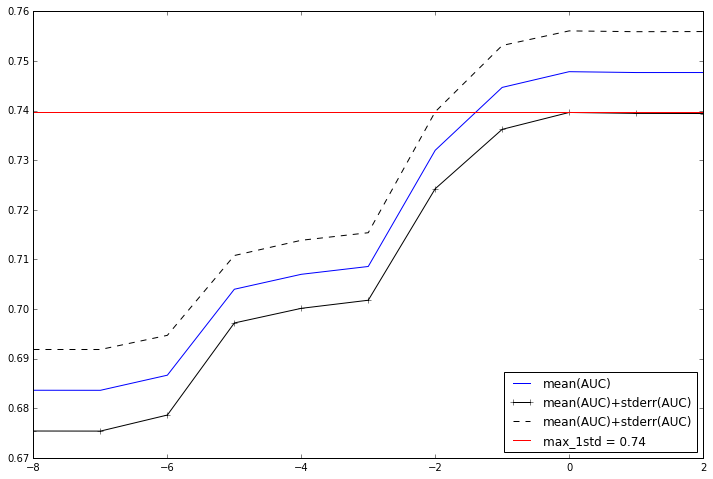

In [7]:
cs = [10**i for i in np.arange(-8,3,1)]
aucs = xValSVM(data_train,'Y',10,cs)

#Create lists that calculate all the desired Ys
mean_AUC = []
StdErr_AUC = []
for c in cs:
    mean_AUC.append(np.mean(aucs[c]))
    StdErr_AUC.append(np.std(aucs[c])/np.sqrt(len(aucs[c])))

minusStd = np.subtract(mean_AUC,StdErr_AUC)
plusStd = np.add(mean_AUC,StdErr_AUC)

#Calculate max_1std and create a list for the plot
max_idx = np.argmax(mean_AUC)
max_1std = mean_AUC[max_idx] - StdErr_AUC[max_idx]
max_1stds = [max_1std for c in cs]

#Create the X list
log_C = np.log10(cs)

fig = plt.figure(figsize = (12, 8))
plt.plot(log_C,mean_AUC, label='mean(AUC)')
plt.plot(log_C,minusStd,'k+-',label='mean(AUC)+stderr(AUC)')
plt.plot(log_C,plusStd,'k--',label='mean(AUC)+stderr(AUC)')
plt.plot(log_C,max_1stds, 'r', label='max_1std = %0.2f'% max_1std)
plt.legend(loc='lower right')
plt.show()

answer here (verbal, no code): No, the out-of-the-box model for SVM had an AUC of 0.758, which uses a c of 1 (or 10^0). This is within the margin of error for the "best" AUC score for the model parameters selected (c from 10^0 to 10^2 all have equivalently the "best" AUC score). If we were to select the least complex model that is above max_1std, we would select c = 10^-1.

### Part 4: Learning Curve with Bootstrapping (8 Points)

In this HW we are trying to find the best linear model to predict if a record represents the Higgs Boson. One of the drivers of the performance of a model is the sample size of the training set.  As a data scientist, sometimes you have to decide if you have enough data or if you should invest in more.  We can use learning curve analysis to determine if we have reached a performance plateau. This will inform us on whether or not we should invest in more data (in this case it would be by running more experiments).

Given a training set of size $N$, we test the performance of a model trained on a subsample of size $N_i$, where $N_i<=N$.  We can plot how performance grows as we move $N_i$ from $0$ to $N$.  

Because of the inherent randomness of subsamples of size $N_i$, we should expect that any single sample of size $N_i$ might not be representative of an algorithm’s performance at a given training set size. To quantify this variance and get a better generalization, we will also use bootstrap analysis. In bootstrap analysis, we pull multiple samples of size $N_i$, build a model, evaluate on a test set, and then take an average and standard error of the results.

An example of using bootstrapping to build a learning curve can be found here: https://github.com/briandalessandro/DataScienceCourse/blob/master/ipython/python35/Lecture_ERM_LogReg_3.ipynb


1\. Create a bootstrap function that can do the following:

def modBootstrapper(train, test, nruns, sampsize, lr, c):

-	Takes as input:
    -	A master training file (train)
    -	A master testing file (test)
    -	Number of bootstrap iterations (nruns) 
    -	Size of a bootstrap sample (sampsize)
    -	An indicator variable to specific LR or SVM (lr=1)
    -	A c option (only applicable to SVM)

-	Runs a loop with (nruns) iterations, and within each loop:
    -	Sample (sampsize) instances from train, with replacement
    -	Fit either an SVM or LR (depending on options specified). For SVM, use the value of C identified using the 1 standard error method from part 3.    
    -	Computes AUC on test data using predictions from model in above step
    -	Stores the AUC in a list

-	Returns the mean(AUC) and Standard Error(mean(AUC)) across all bootstrap samples


In [8]:
# Code here

def modBootstrapper(train, test, nruns, sampsize, lr, c):
    aucList = []
    for run in range(nruns):
        train_sample = train.sample(n=sampsize, replace=True)
        X_train = train_sample.drop('Y', 1)
        Y_train = train_sample['Y']
        X_test = test.drop('Y', 1)
        Y_test = test['Y']
        
        if lr:
            model = linear_model.LogisticRegression(C = 1e30)
        else:
            model = svm.SVC(kernel="linear", C=c)
        
        model.fit(X_train, Y_train)
        
        if lr:       
            test_predict = [i[1] for i in model.predict_proba(X_test)]
        else:
            test_predict = model.decision_function(X_test)
            
        aucList.append(roc_auc_score(Y_test, test_predict))
    
    aucs = [np.mean(aucList),np.std(aucList)/np.sqrt(len(aucList))]
    return aucs

2\. For both LR and SVM, run 20 bootstrap samples for each samplesize in the following list: samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]. (Note, this might take 10-15 mins … feel free to go grab a drink or watch Youtube while this runs).

Generate a plot with the following:
-	Log2(samplesize) on the x-axis
-	2 sets of results lines, one for LR and one for SVM, the set should include
    -	1 series with mean(AUC) for each sampsize (use the color options ‘g’ for svm, ‘r’ for lr)
    -	1 series with mean(AUC)-stderr(AUC) for each c (use ‘+’ as color pattern, ‘g’,’r’ for SVM, LR respectively)
    -	1 series with mean(AUC)+stderr(AUC) for each c (use ‘--‘ as color pattern ‘g’,’r’ for SVM, LR respectively)


In [9]:
#Code here
samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]
AUC_LR = []
AUC_SVM = []

for samples in samplesizes:
    AUC_LR.append(modBootstrapper(data_train,data_test,20,samples,1,10**-1))
    AUC_SVM.append(modBootstrapper(data_train,data_test,20,samples,0,10**-1))

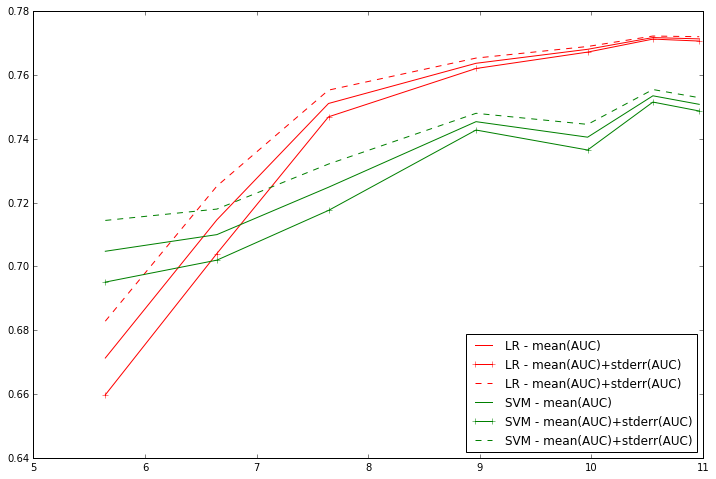

In [10]:
log_sampsize = np.log2(samplesizes)

fig = plt.figure(figsize = (12, 8))

for model in [AUC_LR, AUC_SVM]:
    mean_AUC = [i[0] for i in model]
    StdErr_AUC = [i[1] for i in model]
    minusStd = np.subtract(mean_AUC,StdErr_AUC)
    plusStd = np.add(mean_AUC,StdErr_AUC)
    
    if model == AUC_LR:
        color = 'r'
        modelName = 'LR'
    else:
        color = 'g'
        modelName = 'SVM'

    plt.plot(log_sampsize,mean_AUC, color, label=modelName+' - mean(AUC)')
    plt.plot(log_sampsize,minusStd, color+'+-',label=modelName+' - mean(AUC)+stderr(AUC)')
    plt.plot(log_sampsize,plusStd,color+'--',label=modelName+' - mean(AUC)+stderr(AUC)')
    
plt.legend(loc='lower right') 
plt.show()

3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?


answer here: From the graph, it appears that SVM is slightly better than LR for the smallest sample sizes, however, logistic regression quickly overtakes SVM after that. No, it does not seem to be a worthy investment to pay to double the data. The amount of data we have seems to be already plateauing in terms of AUC performance with only a sample size of 2000.

4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased? (Hint: refer to ESL figure 7.8)?



answer here: Yes, if the number of folds is small and the total number of samples is small too, cross-validation would estimate the performance of the classifier over relatively small training set sizes. That would result in an underestimate of 1-Err, and thus an overestimate of Err. This would cause cross-validation to be biased upward. 